### Image Processing - scc0251

### Assignment 02 - Image Enhancement and filtering

Author: Sérgio Ricardo G. B. Filho - 10408386

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import math

In [10]:
# ----- helper functions ------
def get_rse(input_img, output_img):
    '''
        Performs the RSE calculation between the input_img and the output_img
        
        returns: float value of the calculated RSE
    '''
    #converting images values to float to avoid memory overflow
    rse = 0

    for i in range(1, len(input_img)-1):
        for j in range(1, len(input_img[0]) -1):
            #adding the square of the subtraction of the corresponding pixels
            rse += (input_img[i][j] - output_img[i][j]) ** 2.0
    
    #at last, returns the squared root of the summation
    return math.sqrt(rse)

def scale_image(img):
    '''
        Scales the image using normalization(0 - 255) accordingly to the equation
        given by the pdf
    '''
    min_val = img.min()
    max_val = img.max()

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j] = (img[i][j] - min_val)*255/(max_val-min_val)

def get_gaussian_val(x, sigma):
    """
    Calculates and returns the gaussian kernel value for the given parameters
    """
    return math.exp(-(x**2)/(2*(sigma**2))) / 2 * math.pi * (sigma**2)


# ----- Methods implementation ------

def vignette_filter(input_img, sig_row, sig_col):
    ''' Performs third method '''
    
    rows, cols = input_img.shape  #dimensions of the image
    # initializing w_row and w_col as empty lists
    w_row = []
    w_col = []

    # calculating range to use as reference for gaussian
    row_start, row_end = int(-rows/2), int(rows/2)
    if rows % 2 == 0:   #even number of rows
        row_start = -int(rows/2 - 1)
    col_start, col_end = int(-cols/2), int(cols/2)
    if cols % 2 == 0:   #even number of columns
        col_start = -int(cols/2 - 1)

    # calculating 1D gaussian for w_row
    for i in range(row_start, row_end+1):
        w_row.append(get_gaussian_val(i, sig_row))
    
    # calculating 1D gaussian for w_col
    for i in range(col_start, col_end+1):
        w_col.append(get_gaussian_val(i, sig_col))
    
    # turning lists into numpy arrays
    w_row = np.array(w_row)
    w_col = np.array(w_col)
    
    #multiplying w_col transposed by w_row
    #-> there has been a confusion of which shape order to consider
    # for rows and columns. I chose the configuration that worked
    w_res = np.matmul(w_row[:, None], w_col[None, :])
    
    # multiplying the original image by the 2D kernel
    # and normalizing
    output_img = np.multiply(w_res, input_img)
    scale_image(output_img)

    return output_img

def unsharp_mask(input_img, c, kernel_op):
    ''' Performs second method '''

    #defining which kernel to use
    kernel =  np.matrix([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    if kernel_op == 2:
        kernel = np.matrix([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    
    N, M = input_img.shape  #image dimensions 
    n, m = kernel.shape     #kernel dimensions
    a = int((n-1)/2)
    b = int((m-1)/2)
    
    #initializing output img
    output_img = np.zeros(input_img.shape, dtype=np.float32)
    
    #will compute for each pixel reachable
    for i in range(a, N-a):
        for j in range(b, M-b):
            #selecting centered region
            neighborhood = input_img[i-a : i+a+1, j-b : j+b+1]
            #applying filter
            output_img[i, j] = np.sum( np.multiply(neighborhood, kernel))
    
    #performing first scaling operation
    scale_image(output_img)
    #performing addition
    output_img = output_img * c + input_img
    #performing second scaling operation
    scale_image(output_img)
    
    return output_img

    
def bilateral_filter(input_img, f_size, sig_s, sig_r):
    ''' Performs first method '''
    
    N, M = input_img.shape  #dimensions of the image
    #initializing output img
    output_img = np.zeros(input_img.shape)

    #initializing spatial component with zeros
    spatial_component = np.zeros( (f_size, f_size) )
    a = int((f_size-1)/2)
    b = int((f_size-1)/2)

    #computing the spatial gaussian component for each position of the filter
    for i in range(-a, a+1):
        for j in range(-a, a+1):
            spatial_component[i][j] = get_gaussian_val( math.sqrt(i++2 + j**2), sig_s)
    
    #applying the convolution for each pixel in the image
    for i in range(a, N-a):         #'a' rolls unable to compute
        for j in range(b, M-b):     #'b' colums unable to compute
            
            If = 0      #value of centered pixel
            Wp = 0

            neighborhood = input_img[i-a : i+a+1, j-b : j+b+1]  #region centered at i,j
            If = 0      #new value for the centered pixel

            #for each neighbor inside the window size
            for k in range(-a,a+1):
                for l in range(-b,b+1):
                    #compute value of range component multiplying by correspondent spatial component
                    wi = spatial_component[k][l] * get_gaussian_val(neighborhood[k][l] - input_img[i][j], sig_r)
                    #computing normalization factor (needs to be done before computing the final filter value)
                    Wp += wi
                    
                    #multiplying filter value by its intensity and summing in the total value
                    If += neighborhood[k][l] * wi
            #applying normalization and saving to output 
            output_img[i][j] = If/Wp

        
    return output_img

### Bilateral Filter example

In [23]:
#loading images
img1 = imageio.imread("images/camera.png").astype(np.float32)
img2 = imageio.imread("images/moon.png").astype(np.float32)

(-0.5, 149.5, 149.5, -0.5)

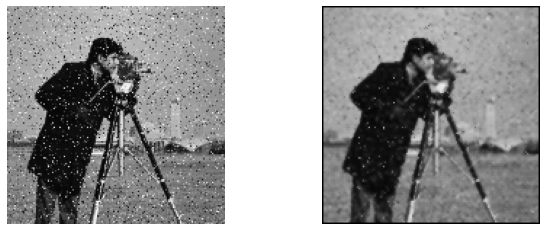

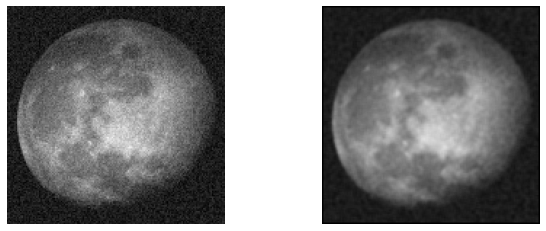

In [24]:
#parameters filter_size=3, sigma_s=150 and sigma_r=100
output_img1 = bilateral_filter(img1, 3, 150.0, 100.0)

#parameters filter_size=5, sigma_s=50 and sigma_r=100
output_img2 = bilateral_filter(img2, 3, 50.0, 100.0)

#plotting camera image before and after
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

#plotting moon image before and after
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

### Method 2 example - Unsharp mask using the Laplacian Filter 

In [28]:
#loading image
img1 = imageio.imread("images/arara.png").astype(np.float32)

(-0.5, 299.5, 299.5, -0.5)

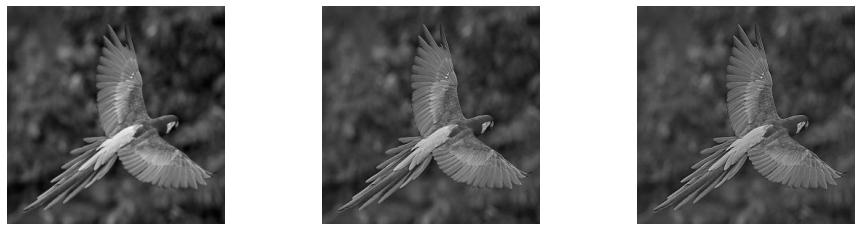

In [29]:
#parameters   c=0.5 and kernel_option=1
output_img1 = unsharp_mask(img1, 0.5, 1)

#parameters   c=0.75 and kernel_option=2
output_img2 = unsharp_mask(img1, 0.75, 2)

#plotting camera image before and after
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(output_img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

### Vignette Filter Example

In [32]:
#loading images
img1 = imageio.imread("images/flower.png").astype(np.float32)
img2 = imageio.imread("images/airplane.png").astype(np.float32)

(-0.5, 198.5, 170.5, -0.5)

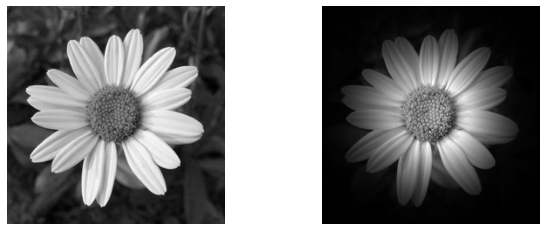

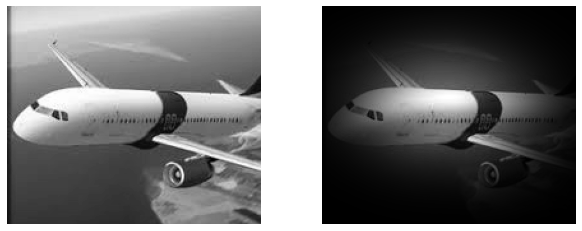

In [33]:
#parameters sigma_row=50 and sigma_col=50
output_img1 = vignette_filter(img1, 50, 50)

#parameters sigma_row=30 and sigma_col=45
output_img2 = vignette_filter(img2, 30, 45)

#plotting camera image before and after
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

#plotting moon image before and after
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(output_img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')